<a href="https://colab.research.google.com/github/mariaeduardagimenes/NLP/blob/master/NLP_Classificador_Sentimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Classificador de Sentimento**


Refere-se ao uso de Processamento de Linguagem Natural a fim de identificar, extrair e quantificar a polaridades expressas nos dados, em formato de texto, podendo ser aplicada também em áudio, vídeo, imagem.

A combinação de NLP e Machine Learning possibilita classificar o sentimento expresso em determinado texto: se é negativo, neutro, positivo, etc.


###**Tipo de Abordagem**

**Machine Learning:** normalmente consiste em modelar os dados de texto no formato BoW (saco de palavras).

- Vantagem: não dependência de idiomas.
- Desvantagem: necessidade de ter dados de treino.


###**Escolha do modelo**
 - Multinomial Naive Bayes
 - Support Vector Machine



###**Definição do problema**

O problema a ser resolvido é criar um classificador de sentimentos.

**Coleta de dados** 

Todo problema de Machine Learning começa com dados. 

Pode ser uma lista de e-mails, posts em redes sociais, tweets, reviews em sites de compras, etc. Podemos coletar usando APIs, fazendo web scrapping, ou utilizar datasets disponíveis na internet.

A base de dados que iremos utilizar foi coletada do Twitter e contém termos referentes a educação e a política do Estado de Minas Gerais.

Os dados já estão rotulados, como positivo, negativo ou neutro. Caso não estivesse, precisariamos utilizar aprendizado não supervisionado para rotular. Porém, podemos utilizar esses dados e treinar um classificador.


In [ ]:
# Primeiramente importamos as bibliotecas que serão utilizadas em nossa anáise:

import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import re
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
import toolz as fp
%matplotlib inline



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# O pandas é uma biblioteca de análise de dados gratuita e de código aberto para Python.
# Ajuda a manipular uma grande quantidade de dados de forma muito rápida e eficiente 

# Vamos usar a função read_csv() do pandas para ler nossa base de dados



import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Tweets_Mg.csv')


,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#**Explorando o dataset**

In [ ]:
df.head()

,Unnamed: 0,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,0,Sun Jan 08 01:22:05 +0000 2017,���⛪ @ Catedral de Santo Antônio - Governador ...,NaN,NaN,Brasil,Leonardo C Schneider,LeoCSchneider,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Sun Jan 08 01:49:01 +0000 2017,"� @ Governador Valadares, Minas Gerais https:/...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Sun Jan 08 01:01:46 +0000 2017,"�� @ Governador Valadares, Minas Gerais https:...",-41.9333,-18.85,NaN,Wândell,klefnews,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Wed Jan 04 21:43:51 +0000 2017,��� https://t.co/BnDsO34qK0,NaN,NaN,NaN,Ana estudando,estudandoconcur,0,Neutro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Mon Jan 09 15:08:21 +0000 2017,��� PSOL vai questionar aumento de vereadores ...,NaN,NaN,NaN,Emily,Milly777,0,Negativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# O atributo shape retorna uma tupla que consiste nas dimensões da Array, 
#mostrando quantas linha e colunas possui nosso dataset.

# Temos 8199 linhas e 26 colunas

df.shape

(8199, 26)

In [ ]:
# Visualizando os dados:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
Created At,Sun Jan 08 01:22:05 +0000 2017,Sun Jan 08 01:49:01 +0000 2017,Sun Jan 08 01:01:46 +0000 2017,Wed Jan 04 21:43:51 +0000 2017,Mon Jan 09 15:08:21 +0000 2017
Text,���⛪ @ Catedral de Santo Antônio - Governador ...,"� @ Governador Valadares, Minas Gerais https:/...","�� @ Governador Valadares, Minas Gerais https:...",��� https://t.co/BnDsO34qK0,��� PSOL vai questionar aumento de vereadores ...
Geo Coordinates.latitude,NaN,-41.9333,-41.9333,NaN,NaN
Geo Coordinates.longitude,NaN,-18.85,-18.85,NaN,NaN
User Location,Brasil,NaN,NaN,NaN,NaN
Username,Leonardo C Schneider,Wândell,Wândell,Ana estudando,Emily
User Screen Name,LeoCSchneider,klefnews,klefnews,estudandoconcur,Milly777
Retweet Count,0,0,0,0,0
Classificacao,Neutro,Neutro,Neutro,Neutro,Negativo


#**Analisando a distribuição de classes do dataset**

Uma das preocupações que existem quando se cria um modelo de classificação é a do enviesamento do mesmo. Uma das formas de isso acontecer é ter, no dataset de treino uma quantidade muito maior de um dos valores da variável alvo em relação aos demais.

No entanto, talvez o classificador só esteja refletindo uma distribuição dos dados reais, porém se isso for um problema do dataset utilizado, o classificador provavelmente errará boa parte das predições.

In [ ]:
# Distribuição das classes da coluna ‘Classificação’:
df.Classificacao.value_counts()

Positivo    3300
Neutro      2453
Negativo    2446
Name: Classificacao, dtype: int64

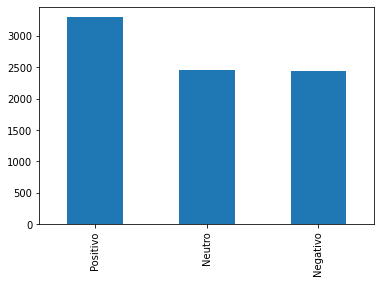

In [ ]:
# Visualizando esses dados graficamente:
df.Classificacao.value_counts().plot(kind='bar')

Estão balanceados.

#**Limpeza e Preparação**

In [ ]:
# Vamos usar a função .rename() para renomear as colunas que queremos, e .loc() para escolhermos quais funções vamos manter


np.random.seed(42)
df = (df
               .rename(columns={"Created At": "data_publicacao",
                                "Text": "tweet",                                
                                "Retweet Count" : "num_retweets",
                                "Username": "usuário",
                                "Classificacao": "sentimento"})
               .loc[:, ["data_publicacao", "tweet", "num_retweets",  "usuário", "sentimento"]])
df["data_publicacao"] = pd.to_datetime(df["data_publicacao"],infer_datetime_format=True)

In [ ]:
df.head()

,data_publicacao,tweet,num_retweets,usuário,sentimento
0,2017-01-08 01:22:05+00:00,���⛪ @ Catedral de Santo Antônio - Governador ...,0,Leonardo C Schneider,Neutro
1,2017-01-08 01:49:01+00:00,"� @ Governador Valadares, Minas Gerais https:/...",0,Wândell,Neutro
2,2017-01-08 01:01:46+00:00,"�� @ Governador Valadares, Minas Gerais https:...",0,Wândell,Neutro
3,2017-01-04 21:43:51+00:00,��� https://t.co/BnDsO34qK0,0,Ana estudando,Neutro
4,2017-01-09 15:08:21+00:00,��� PSOL vai questionar aumento de vereadores ...,0,Emily,Negativo


**Remover linhas duplicadas na base de dados**

No Twitter é muito comum que as pessoas republiquem conteúdos de outrem (retweet). Precisamos tratar isso pois provavelmente existem tweets duplicados em nossa base. 

In [ ]:
#Número de linhas da coluna 'tweet''

df.tweet.count()

8199

In [ ]:
# Removendo os valores duplicados:
df.drop_duplicates(['tweet'], inplace=True)

In [ ]:
#Verificando novamente
df.tweet.count()

5765

De fato nossa base tinha um grande número de valores duplicados. 
É importante remover a duplicidade, pois, dependendo da análise, isso pode alterar o resultado final.

Como vamos analisar apenas as colunas tweet e sentimento, vamos criar colunas para armazenas esses dados.

In [ ]:
# Separando tweets e suas classes:
tweets = df['tweet']
classes = df['sentimento']

**Limpando os dados com Regex**





In [ ]:
# Podemos usar algumas regex (regular expressions) para limpar os dadose salvá-los de volta no disco para uso futuro

# Criando a função standardize_text que vai receber nossos dados, e a coluna desejada como parâmetro
# Vai remover @, http, mudar @ para at, etc. E também transformar todas as palavras
# para letra minúscula,  o que ajuda na hora de não diferencia Palavra de palavra,
# pelo fato de as duas terem o mesmo sentido, apesar de uma iniciar com letra maiúscula

def standardize_text(df1, text_field):
    df1[text_field] = df1[text_field].str.replace(r"http\S+", "")
    df1[text_field] = df1[text_field].str.replace(r"http", "")
    df1[text_field] = df1[text_field].str.replace(r"@\S+", "")
    df1[text_field] = df1[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df1[text_field] = df1[text_field].str.replace(r"@", "em")
    df1[text_field] = df1[text_field].str.lower()
    return df


# Aplicamos a função criada
df = standardize_text(df, "tweet")

# Podemos usar posteriormente esses dados limpos exportando para .csv
df.to_csv("clean_data.csv")

df.head()

,data_publicacao,tweet,num_retweets,usuário,sentimento
0,2017-01-08 01:22:05+00:00,em catedral de santo ant nio governador...,0,Leonardo C Schneider,Neutro
1,2017-01-08 01:49:01+00:00,"em governador valadares, minas gerais",0,Wândell,Neutro
2,2017-01-08 01:01:46+00:00,"em governador valadares, minas gerais",0,Wândell,Neutro
3,2017-01-04 21:43:51+00:00,,0,Ana estudando,Neutro
4,2017-01-09 15:08:21+00:00,psol vai questionar aumento de vereadores ...,0,Emily,Negativo


In [ ]:
# Overview

df.groupby("sentimento").count()

,data_publicacao,tweet,num_retweets,usuário
sentimento,,,,
Negativo,951,951,951,951
Neutro,1974,1974,1974,1974
Positivo,2840,2840,2840,2840


**Verificar as palavras mais frequentes**


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


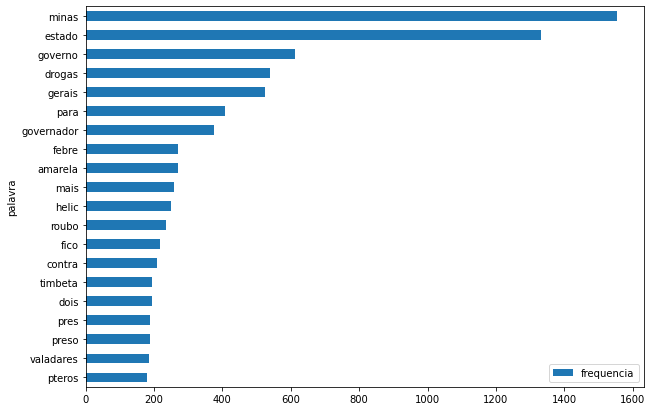

In [ ]:
# Com a biblioteca nltk (própria para NLP) podemos verificar as palavras
# mais frequentes dos tweets. 

# Vamos olhar as 20 palavras mais frequentes, que tem mais de 3 caractéres (evitamos algumas stopwords)

# Aqui já utilizamos tokenização, mas falarei disso mais para frente, na parte de pré-processamento
# Nesse momento é só para visualizar as palavras mais comuns
import nltk
nltk.download('punkt')

tweet_words = nltk.tokenize.word_tokenize(df["tweet"].drop_duplicates().str.lower().str.cat(sep=" ")) # separa em palavras
word_dist = fp.pipe(fp.keyfilter(lambda x: len(x) > 3, nltk.FreqDist(tweet_words)), # apenas palavras com mais de 3 caracteres
                    nltk.probability.FreqDist)

fig, ax = plt.subplots(figsize=(10, 7))

(pd.DataFrame(word_dist.most_common(20)[::-1],
              columns=['palavra', 'frequencia'])
    .plot.barh(x="palavra", y="frequencia", ax=ax));

Os computadores não interpretam letras e dígitos como nós humanos. Os comandos e dados processados pela máquina são transformados em sequencias de 0 e 1.

A biblioteca NLTK contém pacotes para fazer com que as máquinas entendam a linguagem humana.

##**Stopwords**

Palavras e termos que não tem relevância para um texto. 


In [ ]:
# Remover Stopwords

# Stopwords são palavras que não tem relevância para o sentido do texto, ex: uma, um, com, de, que, etc

# nltk possui uma lista de stopwords em 16 idiomas diferentes, e nós vamos criar a função RemoveStopWords() para remover as stopwords em português

def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

#**Stemming**



**Reduzir uma palavra para o seu radical. Remove os sufixos.** 

Ex: gato e gatinho tem o mesmo sentido para um texto, então deixamos na desinência 'gat'para termos melhor noção do texto


In [ ]:
# Stemming


def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))



#**Remover caracteres indesejados, como links, rtc**

In [ ]:
# Remover caracteres indesejados, como links, etc

def Limpeza_dados(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

#**Lemmatization** 

 Reduz as palavras flexionadas adequadamente e determinando a palavra que representa seu lema.

Construções e construir são formas da palavra execução. Execução é o lema dessas palavras

Esse processo só está disponível em inglês, mas utiliza a função WordNetLemmatizer() do pacote nltk

#**Aplicar a função preprocessing()**




In [ ]:

def Preprocessing(instancia):
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','').replace('"','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [ ]:
tweets = [Preprocessing(i) for i in tweets]

In [ ]:
# Vamos visualizar um pouco nossos textos
tweets[:10]

['catedral santo ant nio governador valadares mg',
 'governador valadares, minas gerais',
 'governador valadares, minas gerais',
 '',
 'psol vai questionar aumento vereadores prefeito bh justi politica estado minas',
 'bom bandido morto deputado cabo j lio condenado fica ineleg vel 10 anos politica estado minas',
 '25 mineiros dizem n torcer time nenhum,mesmo dentro estado atl tico mg cruzeiro pq?',
 'gigantesca barba mal destaque caderno cultura estado minas',
 'bb governo minas travam disputa sobre dep sitos judiciais',
 'vcs bh fica pequena! belo horizonte (pron b lo i z nt i 10 capital estado mg, rea aproximadamente 331 km']

#**Vamos visualizar nossa nuvem de palavras**



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


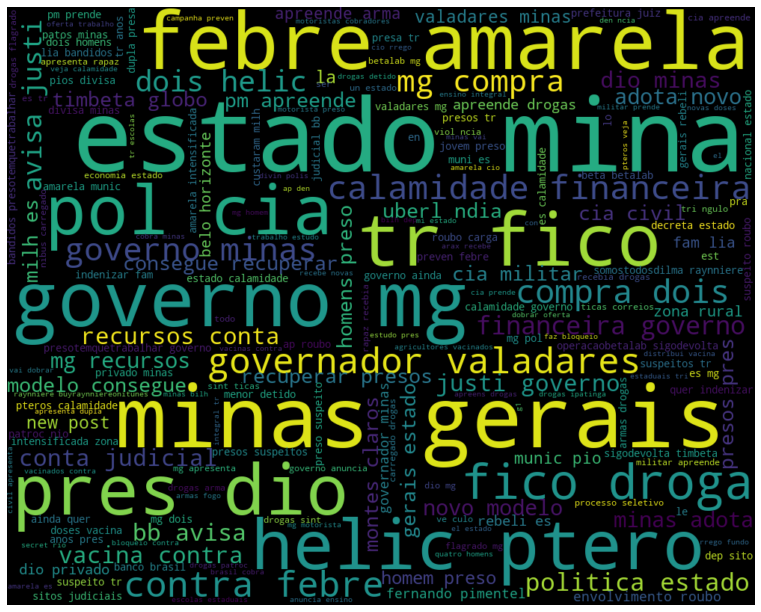

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
nltk

stopwordsPOR = nltk.corpus.stopwords.words('portuguese')

stopwordsPOR

words1 = []
for i in df.tweet:
    for p in i.lower().split():
        if p not in stopwordsPOR and p not in tweets:
         
            words1.append(p)
            
#convert list to string and generate
unique_string=(" ").join(words1)

wordcloud = WordCloud(width=1000, height=800, margin=0).generate(unique_string)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.margins(x=0, y=0)



#**Criar a coluna de tokens**

In [ ]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

df["tokens"] = df["tweet"].apply(tokenizer.tokenize)
df.head()

,data_publicacao,tweet,num_retweets,usuário,sentimento,tokens
0,2017-01-08 01:22:05+00:00,em catedral de santo ant nio governador...,0,Leonardo C Schneider,Neutro,"[em, catedral, de, santo, ant, nio, governador..."
1,2017-01-08 01:49:01+00:00,"em governador valadares, minas gerais",0,Wândell,Neutro,"[em, governador, valadares, minas, gerais]"
2,2017-01-08 01:01:46+00:00,"em governador valadares, minas gerais",0,Wândell,Neutro,"[em, governador, valadares, minas, gerais]"
3,2017-01-04 21:43:51+00:00,,0,Ana estudando,Neutro,[]
4,2017-01-09 15:08:21+00:00,psol vai questionar aumento de vereadores ...,0,Emily,Negativo,"[psol, vai, questionar, aumento, de, vereadore..."


In [ ]:
#Visualizar o número e tamanho dos tweets

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s palavras no total, com um vocabulário de tamanho %s" % (len(all_words), len(VOCAB)))
print("O comprimento máximo de frase é %s" % max(sentence_lengths))





84886 palavras no total, com um vocabulário de tamanho 6136
O comprimento máximo de frase é 35


**Part of Speech (POS Tag)**

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

tagged = df["tokens"].apply(nltk.pos_tag)
#criar tags para cada token
# as tags identificam a classe de cada palavra

tagged

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0       [(em, JJ), (catedral, JJ), (de, FW), (santo, F...
1       [(em, JJ), (governador, NN), (valadares, NNS),...
2       [(em, JJ), (governador, NN), (valadares, NNS),...
3                                                      []
4       [(psol, NN), (vai, NN), (questionar, NN), (aum...
                              ...                        
8194    [(trio, NN), (preso, NN), (suspeito, NN), (de,...
8195    [(trio, NN), (preso, NN), (suspeito, NN), (de,...
8196    [(trio, NN), (preso, NN), (suspeito, NN), (de,...
8197    [(trio, NN), (preso, NN), (suspeito, NN), (de,...
8198    [(trio, NN), (suspeito, NN), (de, IN), (roubo,...
Name: tokens, Length: 5765, dtype: object

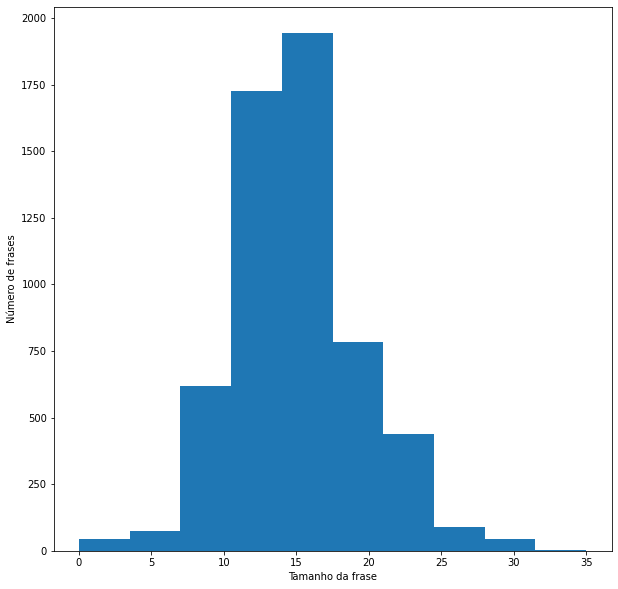

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da frase')
plt.ylabel('Número de frases')
plt.hist(sentence_lengths)
plt.show()

#**Machine Learning**

Em um desafio de NLP as features que irão para o modelo são basicamente as palavras (também chamadas de tokens) ou os n-gramas que compõem os textos, mas temos formas diferentes de metrificar a presença dessas palavras nos textos.

1. WordCount
2. Frequência de termos - TF
3. TF-IDF

In [ ]:
#Pega tweet deixa todo minusculo separa o que é x e o que é y 
#(o que vai ser predito) 
#separa dados de teste e treino
import sklearn
from sklearn import preprocessing

required_columns = ["tweet", "sentimento"]

df["tweet"] = df["tweet"].str.lower()

le = preprocessing.LabelEncoder()

X = df["tweet"]
# y = df['topic']
y = le.fit_transform(df['sentimento'])


X_final_test = df["tweet"]
y_final_test = le.fit_transform(df['sentimento'])


#**BoW**
WordCount

**Unigram**

In [ ]:
count_vec = CountVectorizer()
X_counts = count_vec.fit_transform(X)

**Bigram**

In [ ]:
count_vec_ngram = CountVectorizer(ngram_range=(2, 2))
X_counts_bigram = count_vec_ngram.fit_transform(X)

#**Frequência de Termos - TF**

In [ ]:
tf = TfidfTransformer(use_idf=False, norm="l1")
X_freq = tf.fit_transform(X_counts)

#**TF-IDF**


In [ ]:
tf = TfidfTransformer(norm="l1")
X_tfidf = tf.fit_transform(X_counts)

#**Aplicação de algoritmos**

Nesta seção alguns algoritmos serão aplicados para gerar a classificação de cada um dos sentimentos. 

Dois algoritmos comumente utilizados nesse contexto são: Naive Bayes e Support Vector Machines (SVM).

Mas antes, é preciso dividir o dataset entre treino e teste. Faremos isso na proporção 80% para treino e 20% para testes.

In [ ]:
from sklearn.model_selection import train_test_split

X_train_counts, X_test_counts, y_train_counts, y_test_counts = train_test_split(X_counts, y, test_size=.2)
X_train_bigram, X_test_bigram, y_train_bigram, y_test_bigram = train_test_split(X_counts_bigram, y, test_size=.2)
X_train_freq, X_test_freq, y_train_freq, y_test_freq = train_test_split(X_freq, y, test_size=.2)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=.2)

#**Multinomial Naive Bayes**

In [ ]:
clf_counts = MultinomialNB().fit(X_train_counts, y_train_counts)
clf_bigram = MultinomialNB().fit(X_train_bigram, y_train_bigram)
clf_freq = MultinomialNB().fit(X_train_freq, y_train_freq)
clf_tfidf = MultinomialNB().fit(X_train_tfidf, y_train_tfidf)

In [ ]:
y_pred_counts = clf_counts.predict(X_test_counts)
y_pred_bigram = clf_bigram.predict(X_test_bigram)
y_pred_freq = clf_freq.predict(X_test_freq)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

#**Support Vector Machines**

Como SVM é um modelo paramétrico e não conseguimos aprender os hiper parâmetros através do processo de aprendizagem, nos resta fazer diferentes testes com esses hiperparâmetros. Para isso, usaremos a técnica de GridSearch. Como:

1. GridSearch
2. Cross Validation

In [ ]:
from sklearn.svm import LinearSVC
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'C': [1, 10, 100, 1000]}
 ]
svc = LinearSVC()
clf_counts = GridSearchCV(svc, param_grid).fit(X_train_counts, y_train_counts)
clf_bigram = GridSearchCV(svc, param_grid).fit(X_train_bigram, y_train_bigram)
clf_freq = GridSearchCV(svc, param_grid).fit(X_train_freq, y_train_freq)
clf_tfidf = GridSearchCV(svc, param_grid).fit(X_train_tfidf, y_train_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
svm_y_pred_counts = clf_counts.predict(X_test_counts)
svm_y_pred_bigram = clf_bigram.predict(X_test_bigram)
svm_y_pred_freq = clf_freq.predict(X_test_freq)
svm_y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

#**Avaliação dos modelos**
Para cada um dos modelos, averiguaremos a acurácia dos mesmos

In [ ]:
from sklearn.metrics import accuracy_score

acc_counts = accuracy_score(y_test_counts, y_pred_counts)
acc_bigram = accuracy_score(y_test_bigram, y_pred_bigram)
acc_freq = accuracy_score(y_test_freq, y_pred_freq)
acc_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)

print("Metricas usando MNB")
print("Acuracia de counts = {}".format(acc_counts))
print("Acuracia de bigram = {}".format(acc_bigram))
print("Acuracia de freq = {}".format(acc_freq))
print("Acuracia de tfidf = {}".format(acc_tfidf))
print("-----------------------------------------------------")


svm_acc_counts = accuracy_score(y_test_counts, svm_y_pred_counts)
svm_acc_bigram = accuracy_score(y_test_bigram, svm_y_pred_bigram)
svm_acc_freq = accuracy_score(y_test_freq, svm_y_pred_freq)
svm_acc_tfidf = accuracy_score(y_test_tfidf, svm_y_pred_tfidf)

print("Metricas usando SVM")
print("Acuracia de counts = {}".format(svm_acc_counts))
print("Acuracia de bigram = {}".format(svm_acc_bigram))
print("Acuracia de freq = {}".format(svm_acc_freq))
print("Acuracia de tfidf = {}".format(svm_acc_tfidf))
print("-----------------------------------------------------")

Metricas usando MNB
Acuracia de counts = 0.9306157849089333
Acuracia de bigram = 0.9063313096270599
Acuracia de freq = 0.7432784041630529
Acuracia de tfidf = 0.7085862966175195
-----------------------------------------------------
Metricas usando SVM
Acuracia de counts = 0.9531656548135299
Acuracia de bigram = 0.9392888117953165
Acuracia de freq = 0.9323503902862099
Acuracia de tfidf = 0.9488291413703382
-----------------------------------------------------


A partir da tabela acima, o classificador com melhor resultado será utilizado para classificar os resultados do dataset de testes. Os resultados são apresentados abaixo.

In [ ]:
#Transforma os dados de teste em vetores de palavras com CountVectorizer() e .transform():
X_final_test_counts = count_vec.transform(X_final_test)




In [ ]:
#tf = TfidfTransformer()

# tf = TfidfTransformer()
X_final_test_tfidf = tf.transform(X_final_test_counts)
svm_y_pred = clf_tfidf.predict(X_final_test_tfidf)

acc = accuracy_score(y_final_test, svm_y_pred)

print("Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = {}".format(acc))

Acuracia do melhor classificador (SVM com Unigramas e TF-IDF) = 0.984908933217693


A acurácia do modelo está muito boa.